<a href="https://colab.research.google.com/github/talhaDS04/coffee-shop-sales-analysis/blob/main/Coffee_Shop_Sales_Profitability_%26_Forecast_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Coffee Shop Sales Profitability & Forecast Analysis

## Data Loading
Load the Excel/CSV into the notebook, confirm file integrity and schema, and peek at sample rows.
Record source, file name, row/column counts and basic datatypes.

In [23]:
import pandas as pd
import numpy as np

#Load Dataset ===
df = pd.read_excel("/content/Coffee Shop Sales.xlsx")

print("Initial Shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())
print("\nDuplicates:", df.duplicated().sum())

Initial Shape: (149116, 11)

Missing values:
 transaction_id      0
transaction_date    0
transaction_time    0
transaction_qty     0
store_id            0
store_location      0
product_id          0
unit_price          0
product_category    0
product_type        0
product_detail      0
dtype: int64

Duplicates: 0


## Data Cleaning & Preparation
Parse/merge date & time into transaction_datetime, coerce numeric types, and standardize strings.
Impute obvious missing values, compute total_sales, remove duplicates, and flag critical-missing rows for review.

In [24]:
df.columns = [c.strip() for c in df.columns]

if 'transaction_date' in df.columns and 'transaction_time' in df.columns:
    df['transaction_datetime'] = pd.to_datetime(
        df['transaction_date'].astype(str) + ' ' + df['transaction_time'].astype(str),
        errors='coerce'
    )
else:
    date_cols = [c for c in df.columns if 'date' in c.lower()]
    if date_cols:
        df['transaction_datetime'] = pd.to_datetime(df[date_cols[0]], errors='coerce')
    else:
        df['transaction_datetime'] = pd.NaT

for col in ['transaction_qty', 'unit_price']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

if 'total_sales' not in df.columns:
    df['total_sales'] = df['transaction_qty'] * df['unit_price']

df = df.drop_duplicates().reset_index(drop=True)

# Fill missing unit_price with median price by product
if 'unit_price' in df.columns and 'product_detail' in df.columns:
    median_price_by_product = df.groupby('product_detail')['unit_price'].median()
    df['unit_price'] = df.apply(
        lambda r: median_price_by_product[r['product_detail']]
        if pd.isna(r['unit_price']) and r['product_detail'] in median_price_by_product.index
        else r['unit_price'],
        axis=1
    )

# Fill missing transaction_qty with 1
if 'transaction_qty' in df.columns:
    df['transaction_qty'] = df['transaction_qty'].fillna(1)

# Recalculate total_sales
if 'transaction_qty' in df.columns and 'unit_price' in df.columns:
    df['total_sales'] = df['transaction_qty'] * df['unit_price']

df['critical_missing'] = (
    df['transaction_datetime'].isna() |
    df['product_detail'].isna() |
    df['total_sales'].isna()
)

df_clean = df[~df['critical_missing']].copy()

df_clean['product_detail'] = df_clean['product_detail'].astype(str).str.strip()

df_clean.to_csv("coffee_shop_sales_cleaned.csv", index=False)
print("\nCleaned Shape:", df_clean.shape)
print("Cleaned dataset saved as 'coffee_shop_sales_cleaned.csv'")


Cleaned Shape: (149116, 14)
Cleaned dataset saved as 'coffee_shop_sales_cleaned.csv'


## Exploratory Data Analysis (EDA)
Generate summary statistics and distributions (sales, qty, price) and visualize with bar/line/box plots.
Explore product, category, and store-level patterns to surface anomalies or opportunities.

In [2]:
# importing libraries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import statsmodels.api as sm

In [3]:
!pip install pmdarima openpyxl --quiet
try:
    from pmdarima import auto_arima
    HAVE_PMD = True
except Exception:
    HAVE_PMD = False

plt.rcParams["figure.figsize"] = (12,6)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.6 MB/s eta 0:00:00


In [4]:
CLEANED_CSV = "coffee_shop_sales_cleaned.csv"
COST_PERCENT = 0.60
FORECAST_DAYS = 30
OUTPUT_DIR = "analysis_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [5]:
df = pd.read_csv(CLEANED_CSV, parse_dates=['transaction_datetime'])
print("Loaded:", df.shape)
display(df.head(3))

Loaded: (149116, 14)


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,transaction_datetime,total_sales,critical_missing
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg,2023-01-01 07:06:11,6.0,False
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,2023-01-01 07:08:56,6.2,False
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg,2023-01-01 07:14:04,9.0,False


In [6]:
print("\nColumns:", df.columns.tolist())
print("\nMissing per column:\n", df.isnull().sum())


Columns: ['transaction_id', 'transaction_date', 'transaction_time', 'transaction_qty', 'store_id', 'store_location', 'product_id', 'unit_price', 'product_category', 'product_type', 'product_detail', 'transaction_datetime', 'total_sales', 'critical_missing']

Missing per column:
 transaction_id          0
transaction_date        0
transaction_time        0
transaction_qty         0
store_id                0
store_location          0
product_id              0
unit_price              0
product_category        0
product_type            0
product_detail          0
transaction_datetime    0
total_sales             0
critical_missing        0
dtype: int64


## Profit & Loss Calculation
Estimate product cost (configurable percentage) and compute profit per transaction: profit = total_sales - estimated_cost.
Aggregate profits by product/category/store to see where money is actually made or lost.

In [7]:
df['transaction_qty'] = pd.to_numeric(df['transaction_qty'], errors='coerce').fillna(1).astype(int)
df['unit_price'] = pd.to_numeric(df['unit_price'], errors='coerce')

In [8]:
if 'total_sales' not in df.columns or df['total_sales'].isnull().any():
    df['total_sales'] = df['transaction_qty'] * df['unit_price']

In [9]:
#Derive estimated cost and profit
df['estimated_cost'] = df['unit_price'] * COST_PERCENT * df['transaction_qty']
df['profit'] = df['total_sales'] - df['estimated_cost']
df['profit_margin'] = df['profit'] / df['total_sales'].replace(0, np.nan)

In [10]:
#Save augmented dataset
aug_path = os.path.join(OUTPUT_DIR, "coffee_shop_sales_augmented.csv")
df.to_csv(aug_path, index=False)
print(f"Augmented dataset saved to: {aug_path}")

Augmented dataset saved to: analysis_outputs/coffee_shop_sales_augmented.csv


## Profit Margin Analysis
Calculate product-level profit margins (profit / total_sales) and rank items by margin and total contribution.
Highlight high-margin winners and medium-margin items that could scale.

In [11]:
# Product-level summary
product_summary = df.groupby('product_detail').agg(
    transaction_qty=('transaction_qty','sum'),
    total_sales=('total_sales','sum'),
    estimated_cost=('estimated_cost','sum'),
    profit=('profit','sum')
).reset_index()
product_summary['profit_margin'] = product_summary['profit'] / (product_summary['total_sales'].replace(0, np.nan))

In [12]:
# Category-level summary (if product_category exists)
if 'product_category' in df.columns:
    category_summary = df.groupby('product_category').agg(
        transaction_qty=('transaction_qty','sum'),
        total_sales=('total_sales','sum'),
        estimated_cost=('estimated_cost','sum'),
        profit=('profit','sum')
    ).reset_index()
    category_summary['profit_margin'] = category_summary['profit'] / category_summary['total_sales'].replace(0, np.nan)
    category_summary.to_csv(os.path.join(OUTPUT_DIR, "category_summary.csv"), index=False)

In [13]:
# Store-level summary (if store_location exists)
if 'store_location' in df.columns:
    store_summary = df.groupby('store_location').agg(transaction_qty=('transaction_qty','sum'),
                                                     total_sales=('total_sales','sum'),
                                                     profit=('profit','sum')).reset_index()
    store_summary['profit_margin'] = store_summary['profit'] / store_summary['total_sales'].replace(0, np.nan)
    store_summary.to_csv(os.path.join(OUTPUT_DIR, "store_summary.csv"), index=False)

## Loss-Making Products Identification
List products with negative total profit and inspect their volumes, prices, and unit costs.
Diagnose whether losses are due to pricing, low price/volume mismatch, or high assumed costs.

In [14]:
# Top products by sales & profit
top_by_sales = product_summary.sort_values('total_sales', ascending=False).head(20)
top_by_profit = product_summary.sort_values('profit', ascending=False).head(20)
loss_makers = product_summary[product_summary['profit'] < 0].sort_values('profit').head(20)

product_summary.to_csv(os.path.join(OUTPUT_DIR, "product_summary.csv"), index=False)

print("\nTop 10 products by total sales:")
display(top_by_sales.head(10))

print("\nTop 10 products by profit:")
display(top_by_profit.head(10))

print("\nTop loss-making products:")
display(loss_makers.head(10))


Top 10 products by total sales:


,product_detail,transaction_qty,total_sales,estimated_cost,profit,profit_margin
75,Sustainably Grown Organic Lg,4453,21151.75,12691.05,8460.7,0.4
20,Dark chocolate Lg,4668,21006.00,12603.60,8402.4,0.4
48,Latte Rg,4497,19112.25,11467.35,7644.9,0.4
6,Cappuccino Lg,4151,17641.75,10585.05,7056.7,0.4
53,Morning Sunrise Chai Lg,4346,17384.00,10430.40,6953.6,0.4
47,Latte,4602,17257.50,10354.50,6903.0,0.4
43,Jamaican Coffee River Lg,4395,16481.25,9888.75,6592.5,0.4
76,Sustainably Grown Organic Rg,4329,16233.75,9740.25,6493.5,0.4
5,Cappuccino,4266,15997.50,9598.50,6399.0,0.4
2,Brazilian Lg,4317,15109.50,9065.70,6043.8,0.4



Top 10 products by profit:


,product_detail,transaction_qty,total_sales,estimated_cost,profit,profit_margin
75,Sustainably Grown Organic Lg,4453,21151.75,12691.05,8460.7,0.4
20,Dark chocolate Lg,4668,21006.00,12603.60,8402.4,0.4
48,Latte Rg,4497,19112.25,11467.35,7644.9,0.4
6,Cappuccino Lg,4151,17641.75,10585.05,7056.7,0.4
53,Morning Sunrise Chai Lg,4346,17384.00,10430.40,6953.6,0.4
47,Latte,4602,17257.50,10354.50,6903.0,0.4
43,Jamaican Coffee River Lg,4395,16481.25,9888.75,6592.5,0.4
76,Sustainably Grown Organic Rg,4329,16233.75,9740.25,6493.5,0.4
5,Cappuccino,4266,15997.50,9598.50,6399.0,0.4
2,Brazilian Lg,4317,15109.50,9065.70,6043.8,0.4



Top loss-making products:


,product_detail,transaction_qty,total_sales,estimated_cost,profit,profit_margin


## Sales Trend & Time-Series Analysis
Aggregate sales to daily (or weekly) series and decompose into trend, seasonality, and residuals.
Look for recurring patterns (weekday/weekend, monthly) and abnormal events.

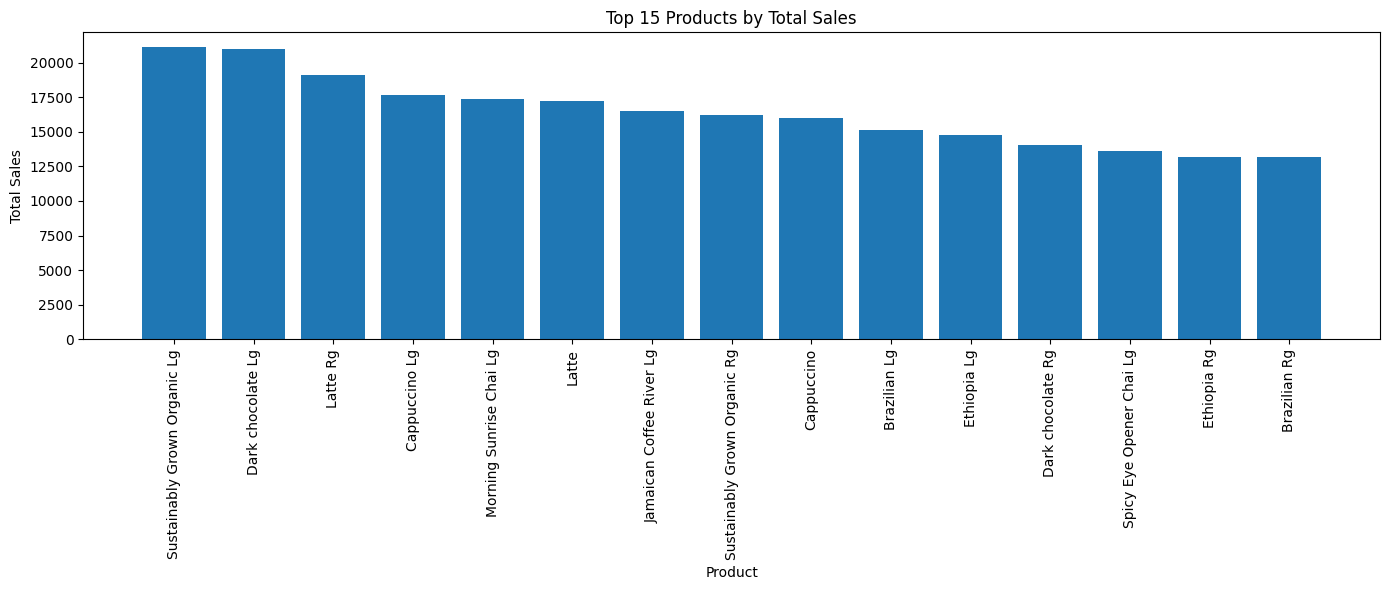

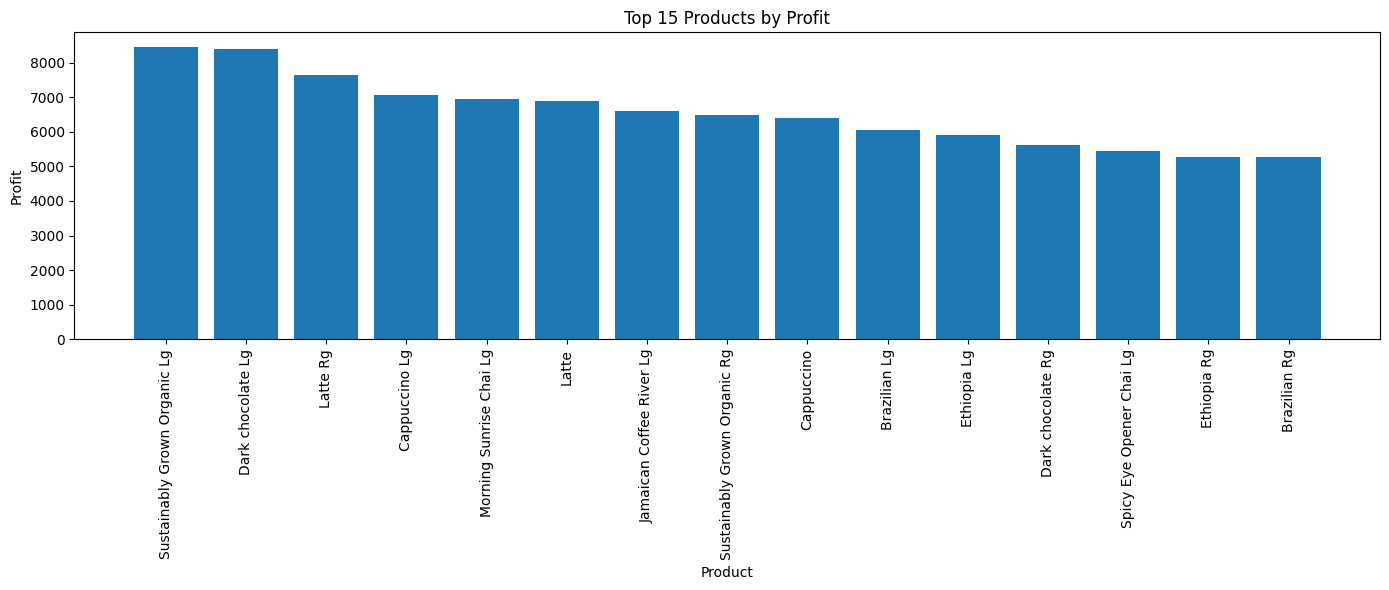

In [15]:
def bar_plot_top(df_, xcol, ycol, top_n=20, title="", xlabel="", ylabel="", fname=None, rotate_x=True):
    top = df_.sort_values(ycol, ascending=False).head(top_n)
    plt.figure(figsize=(14,6))
    plt.bar(top[xcol].astype(str), top[ycol])
    if rotate_x:
        plt.xticks(rotation=90)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=150)
    plt.show()

bar_plot_top(product_summary, 'product_detail', 'total_sales', top_n=15,
             title="Top 15 Products by Total Sales", xlabel="Product", ylabel="Total Sales",
             fname=os.path.join(OUTPUT_DIR, "top_products_by_sales.png"))

bar_plot_top(product_summary, 'product_detail', 'profit', top_n=15,
             title="Top 15 Products by Profit", xlabel="Product", ylabel="Profit",
             fname=os.path.join(OUTPUT_DIR, "top_products_by_profit.png"))

## Forecasting Future Sales
Fit ARIMA/SARIMAX or auto_arima to forecast the next 30 days (include confidence intervals).
Validate with backtesting (holdout period) and report forecast accuracy (MAE/MAPE).


Daily sales head:


,total_sales
transaction_datetime,
2023-01-01,2508.20
2023-01-02,2403.35
2023-01-03,2565.00
2023-01-04,2220.10
2023-01-05,2418.85


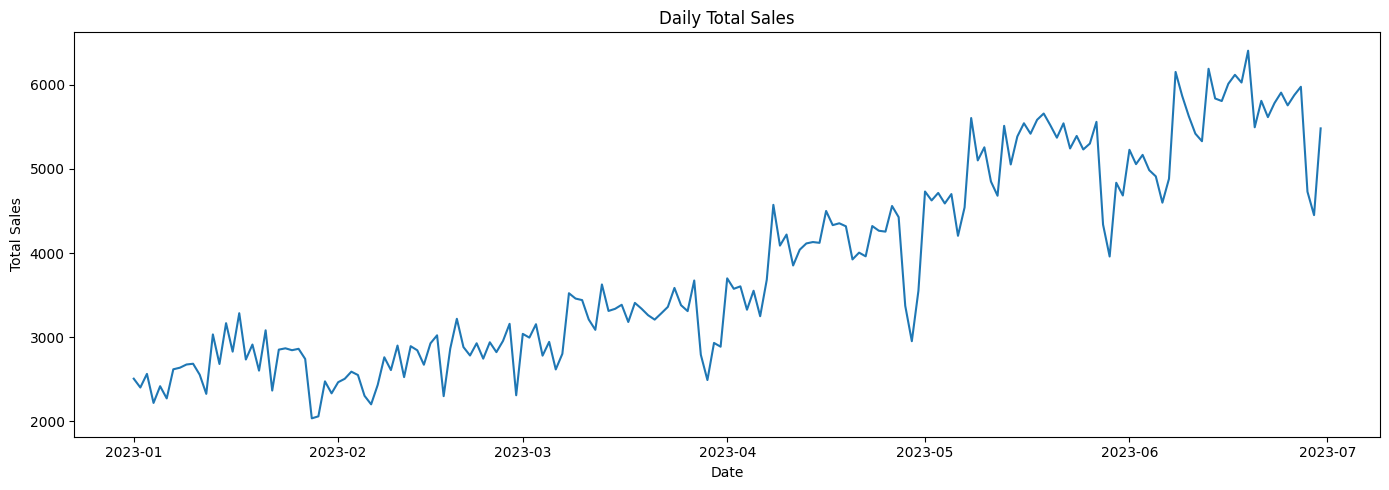

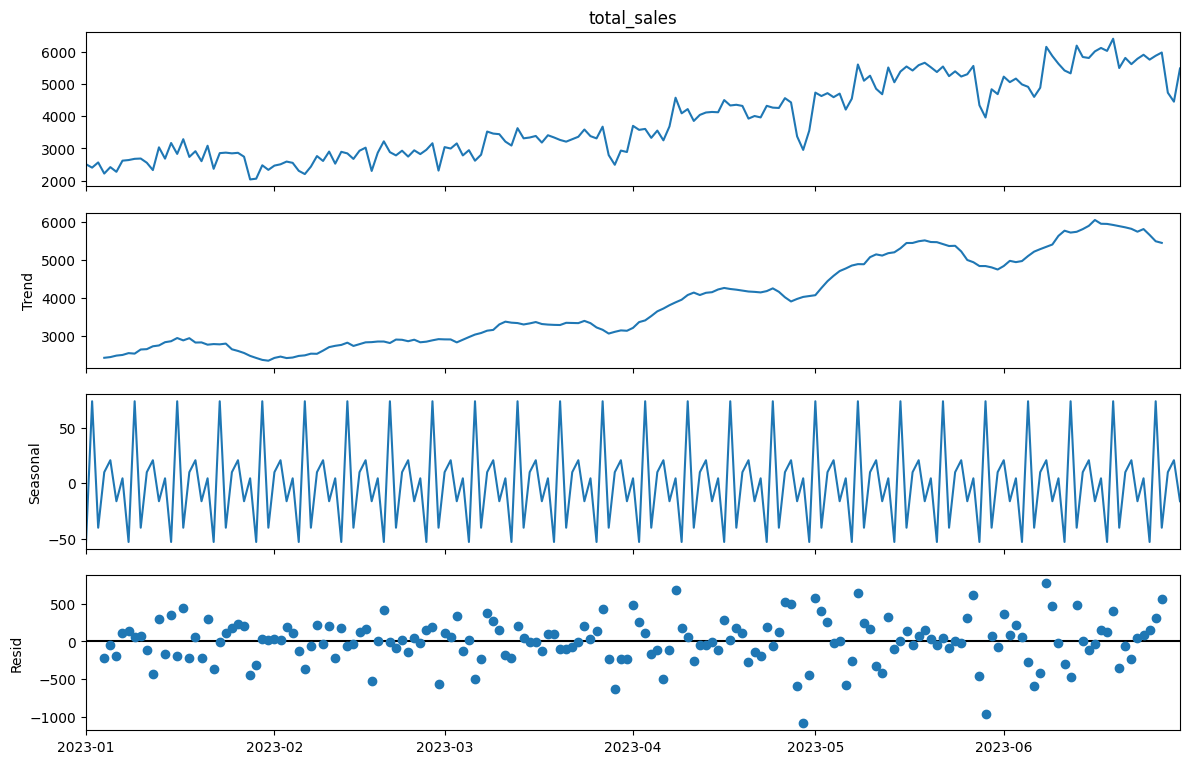


Using SARIMAX fallback (simple parameters). Consider installing pmdarima for auto tuning.


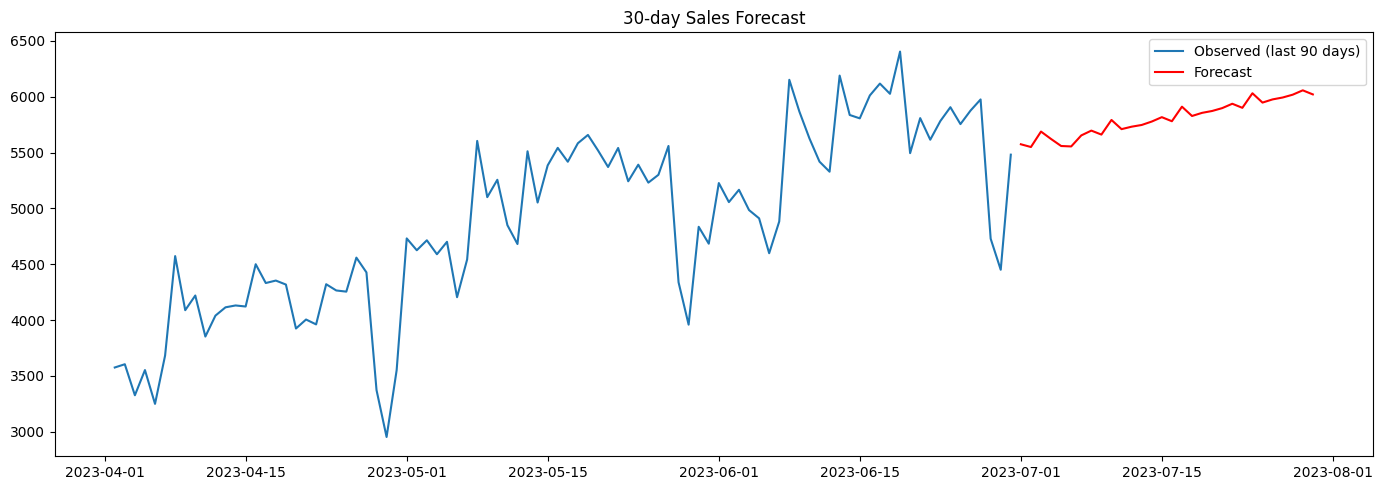

In [16]:
if 'transaction_datetime' in df.columns:
    daily_sales = df.set_index('transaction_datetime').resample('D')['total_sales'].sum().fillna(0)
    daily_sales = daily_sales.sort_index()
    daily_sales.to_csv(os.path.join(OUTPUT_DIR, "daily_sales.csv"))
    print("\nDaily sales head:")
    display(daily_sales.head())

    # Plot daily sales
    plt.figure(figsize=(14,5))
    plt.plot(daily_sales.index, daily_sales.values)
    plt.title("Daily Total Sales")
    plt.xlabel("Date")
    plt.ylabel("Total Sales")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "daily_sales_plot.png"))
    plt.show()

    # Seasonal decomposition (additive)
    try:
        decomposition = sm.tsa.seasonal_decompose(daily_sales, model='additive', period=7)
        fig = decomposition.plot()
        fig.set_size_inches(12,8)
        fig.savefig(os.path.join(OUTPUT_DIR, "decomposition.png"), dpi=150)
        plt.show()
    except Exception as e:
        print("Could not run decomposition:", e)

    # Forecasting: auto_arima if available, else SARIMAX
    if HAVE_PMD:
        print("\nRunning auto_arima (pmdarima) to find best order...")
        model = auto_arima(daily_sales, seasonal=True, m=7, trace=False,
                           error_action='ignore', suppress_warnings=True,
                           stepwise=True)
        print("Found order:", model.order, "seasonal_order:", model.seasonal_order)
        forecast = model.predict(n_periods=FORECAST_DAYS)
        forecast_index = pd.date_range(daily_sales.index.max() + pd.Timedelta(days=1), periods=FORECAST_DAYS, freq='D')
        forecast_series = pd.Series(forecast, index=forecast_index)
    else:
        print("\nUsing SARIMAX fallback (simple parameters). Consider installing pmdarima for auto tuning.")
        try:
            # A simple SARIMAX with (1,1,1)(1,1,1,7)
            sar = sm.tsa.SARIMAX(daily_sales, order=(1,1,1), seasonal_order=(1,1,1,7), enforce_stationarity=False, enforce_invertibility=False)
            res = sar.fit(disp=False)
            forecast = res.get_forecast(steps=FORECAST_DAYS)
            forecast_series = forecast.predicted_mean
        except Exception as e:
            print("SARIMAX failed:", e)
            forecast_series = None

    if isinstance(forecast_series, pd.Series):
        plt.figure(figsize=(14,5))
        plt.plot(daily_sales.index[-90:], daily_sales.values[-90:], label='Observed (last 90 days)')
        plt.plot(forecast_series.index, forecast_series.values, label='Forecast', color='red')
        plt.title(f'{FORECAST_DAYS}-day Sales Forecast')
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, "sales_forecast.png"), dpi=150)
        plt.show()
        forecast_series.to_csv(os.path.join(OUTPUT_DIR, f"sales_forecast_{FORECAST_DAYS}d.csv"))
else:
    print("No transaction_datetime column to run time-series analysis.")

## Regression Analysis for Profit Drivers
Aggregate product features (avg price, qty, category) and run a simple regression or OLS to find factors associated with higher profit.
Use coefficients to infer actionable levers (e.g., price sensitivity, volume effects).

In [17]:
prod_features = product_summary.copy()
prod_features['avg_unit_price'] = df.groupby('product_detail')['unit_price'].mean().reindex(prod_features['product_detail']).values
prod_features['avg_qty'] = df.groupby('product_detail')['transaction_qty'].mean().reindex(prod_features['product_detail']).values
prod_features = prod_features.replace([np.inf, -np.inf], np.nan).fillna(0)

In [18]:
# Keeping a small regression model (OLS)
import statsmodels.formula.api as smf
prod_features['log_total_sales'] = np.log1p(prod_features['total_sales'])
prod_features['log_profit'] = np.log1p(prod_features['profit'].clip(lower=0))  # only non-negative profits for log

In [19]:
# Fitting a simple OLS on log_total_sales -> profit (only for products with profit > 0)
reg_df = prod_features[prod_features['profit'] > 0].copy()
if len(reg_df) >= 10:
    reg = smf.ols("profit ~ total_sales + avg_unit_price + transaction_qty", data=reg_df).fit()
    print("\nRegression summary (predicting product profit):")
    print(reg.summary())
    coef_path = os.path.join(OUTPUT_DIR, "regression_coefficients.csv")
    pd.DataFrame(reg.params, columns=["coef"]).to_csv(coef_path)
else:
    print("\nNot enough profitable products to run stable regression model (need >= 10).")


Regression summary (predicting product profit):
                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.207e+31
Date:                Sat, 09 Aug 2025   Prob (F-statistic):               0.00
Time:                        12:02:08   Log-Likelihood:                 2044.4
No. Observations:                  80   AIC:                            -4081.
Df Residuals:                      76   BIC:                            -4071.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

## Recommendations & Action Plan
Translate findings into prioritized actions: price adjustments, promos, bundling, inventory changes, supplier renegotiation.
For each action provide expected impact, required effort, and next steps for implementation.

In [20]:
def generate_recommendations(prod_df, top_n=10):
    recs = []
    top_prof = prod_df.sort_values('profit', ascending=False).head(top_n)
    for _, r in top_prof.iterrows():
        recs.append(f"Increase inventory & marketing for '{r['product_detail']}' — high profit (profit={r['profit']:.2f}).")

    top_loss = prod_df[prod_df['profit'] < 0].sort_values('profit').head(top_n)
    for _, r in top_loss.iterrows():
        recs.append(f"Review '{r['product_detail']}' (loss={r['profit']:.2f}). Options: increase price, reduce portion/cost, bundle with top-seller, or discontinue if low volume.")
    return recs

recommendations = generate_recommendations(product_summary, top_n=8)

## Report & Presentation Preparation
Compile the cleaned dataset, methods, key charts, forecast outputs, and recommendations into a report and slide deck.
Include an appendix with the cleaning log and runnable notebook for reproducibility.

In [21]:
# Save recommendations & summaries
with open(os.path.join(OUTPUT_DIR, "recommendations.txt"), "w") as f:
    f.write("\n".join(recommendations))

print("\n=== Top Recommendations (sample) ===")
for rec in recommendations[:10]:
    print("-", rec)


=== Top Recommendations (sample) ===
- Increase inventory & marketing for 'Sustainably Grown Organic Lg' — high profit (profit=8460.70).
- Increase inventory & marketing for 'Dark chocolate Lg' — high profit (profit=8402.40).
- Increase inventory & marketing for 'Latte Rg' — high profit (profit=7644.90).
- Increase inventory & marketing for 'Cappuccino Lg' — high profit (profit=7056.70).
- Increase inventory & marketing for 'Morning Sunrise Chai Lg' — high profit (profit=6953.60).
- Increase inventory & marketing for 'Latte' — high profit (profit=6903.00).
- Increase inventory & marketing for 'Jamaican Coffee River Lg' — high profit (profit=6592.50).
- Increase inventory & marketing for 'Sustainably Grown Organic Rg' — high profit (profit=6493.50).


In [22]:
product_summary.to_csv(os.path.join(OUTPUT_DIR, "product_profit_summary.csv"), index=False)
print(f"\nAll outputs saved in folder: {OUTPUT_DIR}")


All outputs saved in folder: analysis_outputs
